# Modeling 

Having fully processed my data I am now ready to begin testing model to find the best move forward with for this data set. Based on previous experience I am choosing to test decision tree, KNN, random forest, and XGBoost 

### Table of Content

1. [Load Packages](#part1) 
2. [Split, Vectorize, and Concat](#part2)
3. [Model Testing](#part3)  
    1.[Decision Tree](#part3a) 
    2.[Random Forest](#part3b) 
    3.[XGBoost](#part3c)
    4.[KNN](#part3d) 
    5.[Light Gradient Boosted Machine (LightGBM)](#part3e)
4. [Conclusion and Next Steps](#part4) 


<a name="part1"></a>
## Load Packages and Prepare Dataframe 

There are a few columns I will need to drop before train test split and I will do that here. 

In [1]:
#import packages
import pandas as pd
import numpy as np 

#Imports for plotting
from ast import literal_eval 
import pickle
import seaborn as sns
import matplotlib.pyplot as plt   
%matplotlib inline

#options
pd.options.mode.chained_assignment = None
pd.set_option('display.max_colwidth', 100)
pd.options.display.max_rows = 50
import warnings
warnings.filterwarnings('ignore') 

#NLP Packages
import nltk
from nltk.collocations import *
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist 
from nltk import RegexpTokenizer, PorterStemmer, pos_tag  
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
import string
import re   
from mpl_toolkits.mplot3d import Axes3D

# sklearn
from sklearn.feature_extraction.text import TfidfTransformer  
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, f1_score, recall_score, confusion_matrix

# xgboost
from xgboost import XGBClassifier



In [2]:
#Load data
df = pd.read_pickle('df_processed_full.pickle')

#Preview dataset
df.head(1)

,rating_overall,employee_title_title_known,employee_title_title_unknown,employee_status_current_employee,employee_status_former_employee,employee_status_unknown_status,helpful_helpful,helpful_not_helpful,recommends_does_not_recommend,recommends_recommends,...,adv,verb,characters,tokens,words,sentences,avg_word_len,avg_sent_len,stem_str,sentiment
0,5.0,1,0,1,0,0,0,1,0,1,...,0.181818,0.181818,94,11,17,3,5.529412,5.666667,great alway room improv everybodi work togeth con love job helpfu,0.65


In [3]:
needed = ['rating_overall', 'employee_title_title_known','employee_title_title_unknown', 'employee_status_current_employee', 
          'employee_status_former_employee', 'employee_status_unknown_status', 'helpful_helpful', 'helpful_not_helpful','recommends_does_not_recommend',
          'recommends_recommends','recommends_unknown_recommends', 'area_central', 'area_east_coast','area_mountain', 'area_outside_US', 
          'area_unknown', 'area_west_coast','company_outlook_negative_outlook', 'company_outlook_neutral_outlook',
          'company_outlook_outlook_unknown', 'company_outlook_positive_outlook', 'opinion_of_CEO_approves_of_CEO', 
          'opinion_of_CEO_disapproves_of_CEO', 'opinion_of_CEO_no_opinion_of_CEO','opinion_of_CEO_unknown_opinion_of_CEO', 
           'noun', 'adj', 'adv', 'verb', 'characters','tokens', 'words', 'sentences', 'avg_word_len', 'avg_sent_len', 'stem_str', 'sentiment']

dfa = df[needed] 

<a name="part2"></a>
## Split, Vectorize, and Concat 

Now my data is ready to split into testing and training sets, vectorize the text column, and concat it back with the rest of the data set.

In [4]:
# Seperate target from features 
X = dfa.drop(columns=['rating_overall'])
y = df['rating_overall']

# Splitting data into testing and traning sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=21)

In [5]:
#Check the shae
print(X_train.shape) 
print(X_test.shape)

(2985, 36)
(11941, 36)


In [6]:
#Set up TFIDF Vectorizer using bigrams and trigrams
vectorizer = TfidfVectorizer(ngram_range=(2, 3),  # include uni and 3-rams only
                            max_df=.999, min_df=.0025) 

In [7]:
#Apply Vectorizer
tfidf_data_train = vectorizer.fit_transform(X_train['stem_str'])
tfidf_data_test = vectorizer.transform(X_test['stem_str'])

In [8]:
print(tfidf_data_train.shape) 
print(tfidf_data_test.shape)

(2985, 981)
(11941, 981)


In [9]:
#Drop original text columns
X_train = X_train.drop(columns=['stem_str'])
X_test = X_test.drop(columns=['stem_str'])

In [10]:
#Check number of zero columns and percent
non_zero_cols = tfidf_data_train.nnz / float(tfidf_data_train.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train.shape[1]))
print('Percentage of columns containing 0: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 6.588274706867671
Percentage of columns containing 0: 0.9932841236423368


In [11]:
# Convert tfidf to array and concatenate train and test sets
X_train = pd.concat([pd.DataFrame(tfidf_data_train.toarray()), X_train.reset_index()], axis = 1)
X_test = pd.concat([pd.DataFrame(tfidf_data_test.toarray()), X_test.reset_index()], axis = 1)

<a name="part3"></a>
## Model Testing 

Below I will run decision tree, random forest, xgboost, and knn to see which one gives the best results for my data before moving on to tuning that model.

<a name="part3a"></a>
### Decision Tree

In [12]:
#Import packages
from sklearn.tree import DecisionTreeClassifier

In [13]:
#Instantiate Decision tree model
clf = DecisionTreeClassifier(criterion='entropy', random_state=23)
#Fit the model to data
clf.fit(X_train, y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=23, splitter='best')

In [14]:
#Run Test Predictions
dt_test_preds = clf.predict(X_test)

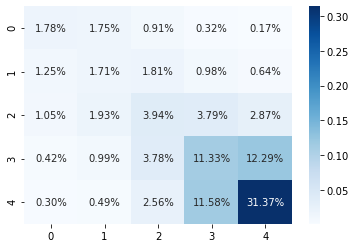

In [15]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, dt_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [16]:
#Run Metrics
rf_recall = recall_score(y_test, dt_test_preds, average='weighted')
rf_acc_score = accuracy_score(y_test, dt_test_preds)
rf_f1_score = f1_score(y_test, dt_test_preds, average='weighted')
print('Decision Tree:')
print(3*'-----')

print('Recall: {:.4}'.format(rf_recall))
print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Decision Tree:
---------------
Recall: 0.5013
Testing Accuracy: 0.5013
F1 Score: 0.4999


<a name="part3b"></a>
### Random Forest

In [17]:
#Initialize Classifier 
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=23)
#Fit Classifier to Data
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=23, verbose=0,
                       warm_start=False)

In [18]:
#Run Test Predictions
rf_test_preds = rf_classifier.predict(X_test)

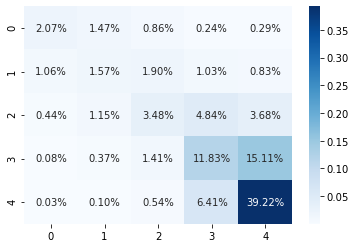

In [19]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, rf_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [20]:
#Run Metrics
rf_recall = recall_score(y_test, rf_test_preds, average='weighted')
rf_acc_score = accuracy_score(y_test, rf_test_preds)
rf_f1_score = f1_score(y_test, rf_test_preds, average='weighted')
print('Random Forest with Stematized Features:')
print(3*'-----')

print('Recall: {:.4}'.format(rf_recall))
print("Testing Accuracy: {:.4}".format(rf_acc_score))
print("F1 Score: {:.4}".format(rf_f1_score))

Random Forest with Stematized Features:
---------------
Recall: 0.5817
Testing Accuracy: 0.5817
F1 Score: 0.558


<a name="part3c"></a>
### XGBoost

In [21]:
#Instantiate Model
xgb = XGBClassifier(random_state=23)
#Fit model to the data
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=23,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [22]:
#Run predictions
xgb_test_preds = xgb.predict(X_test)

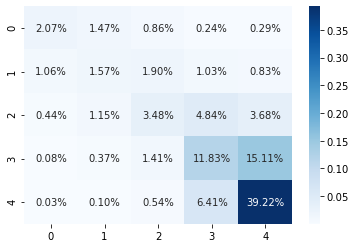

In [23]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, rf_test_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [24]:
#Run metrics
xgb_recall = recall_score(y_test, xgb_test_preds, average='weighted')
xgb_acc_score = accuracy_score(y_test, xgb_test_preds)
xgb_f1_score = f1_score(y_test, xgb_test_preds, average='weighted')

print('XGBOOST:')
print(3*'-----')

print('Recall: {:.4}'.format(xgb_recall))

print("Testing Accuracy: {:.4}".format(xgb_acc_score))
print("F1 Score: {:.4}".format(xgb_f1_score))

XGBOOST:
---------------
Recall: 0.5856
Testing Accuracy: 0.5856
F1 Score: 0.5674


<a name="part3d"></a>
### KNN 

In [25]:
from sklearn.neighbors import KNeighborsClassifier 

#Scale X_train and X_test for knn
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [26]:
# Instantiate KNeighborsClassifier
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(scaled_X_train, y_train)

# Predict on the test set
knn_preds = clf.predict(scaled_X_test)

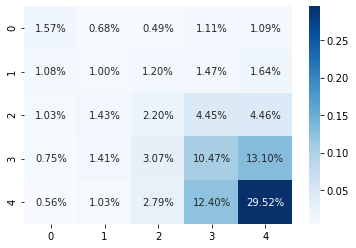

In [27]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, knn_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [28]:
#Run metrics
xgb_recall = recall_score(y_test, knn_preds, average='weighted')
xgb_acc_score = accuracy_score(y_test, knn_preds)
xgb_f1_score = f1_score(y_test, knn_preds, average='weighted')

print('KNN:')
print(3*'-----')

print('Recall: {:.4}'.format(xgb_recall))

print("Testing Accuracy: {:.4}".format(xgb_acc_score))
print("F1 Score: {:.4}".format(xgb_f1_score))

KNN:
---------------
Recall: 0.4477
Testing Accuracy: 0.4477
F1 Score: 0.4392


<a name="part3e"></a>
### Light Gradient Boosted Machine (LightGBM) 

In [36]:
#Import Light GBM
from lightgbm import LGBMClassifier

# define the model
lgbm = LGBMClassifier(random_state=66)

#Fit model to the data
lgbm.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=66, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [37]:
#Run predictions
lgm_test_preds = lgbm.predict(X_test)

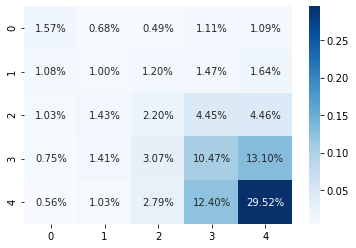

In [38]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, knn_preds)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues') 
plt.show()

In [39]:
#Run metrics
xgb_recall = recall_score(y_test, lgm_test_preds, average='weighted')
xgb_acc_score = accuracy_score(y_test, lgm_test_preds)
xgb_f1_score = f1_score(y_test, lgm_test_preds, average='weighted')

print('LGBM:')
print(3*'-----')

print('Recall: {:.4}'.format(xgb_recall))

print("Testing Accuracy: {:.4}".format(xgb_acc_score))
print("F1 Score: {:.4}".format(xgb_f1_score))

LGBM:
---------------
Recall: 0.581
Testing Accuracy: 0.581
F1 Score: 0.5719


<a name="part4"></a>
### Conclusion 

In the end my best model was XGBoost with 59% accuracy. This indicates it was able to accurately classfy reviews 59% percent of the time. This indicates that machine learning could be a better way to score company reviews and this the overall company rating versus relying on a self reported score. For my next steps I will try to improve on my two best models using grid search to see if I can improve accuracy scores. 